In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('perrin-freres-monthly-champagne-.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [47]:
df.columns = ['Month','Sales']
df

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


Dropping null values

In [48]:
df = df.dropna()

Converting Months column to DateTime dtype

In [49]:
df['Month'] = pd.to_datetime(df['Month'])
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [50]:
df.set_index('Month',inplace = True)

In [51]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


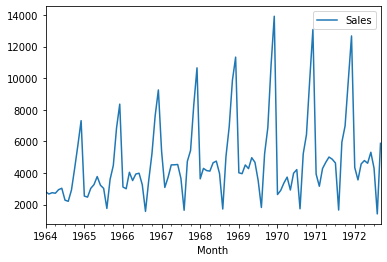

In [53]:
df.plot()

## Differencing

In [54]:
mean_log = df.rolling(window=12).mean()
std_log = df.rolling(window=12).std()
mean_log.head(20)

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
1964-06-01,NaN
1964-07-01,NaN
1964-08-01,NaN
1964-09-01,NaN


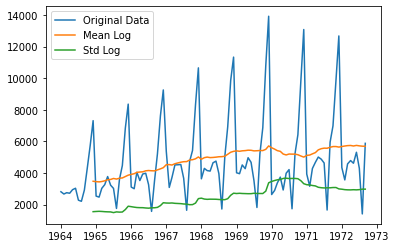

In [55]:
plt.plot(df,label = 'Original Data')
plt.plot(mean_log,label = 'Mean Log')
plt.plot(std_log,label = 'Std Log')
plt.legend(loc = 'best')
plt.show()

In [56]:
#adfuller test for stationarity
test_og = adfuller(df['Sales'])
test_og

(-1.8335930563276188,
 0.363915771660247,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

### Function for Dickey Fuller test

In [57]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(data):
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    test = adfuller(data)
    for label,value in zip(labels,test):
        print(f"{label} : {value}")
    if test[1] > 0.05:
        print("Data is Non Stationary & we accept the null hypothesis")
    else:
        print("Data is Stationary & we reject the null hypothesis")

In [58]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276188
p-value : 0.363915771660247
#Lags Used : 11
Number of Observations Used : 93
Data is Non Stationary & we accept the null hypothesis


### Converting our non stationary data to stationary data
Before building a time series model, we need to make sure that the time series is stationary. If the time series is non-stationary, then we need to make it stationary by differencing the data. The number of times we take a difference of the data is a parameter used in ARIMA models, which we will see shortly.

Non-stationarity in time series may appear for the following reasons:

Presence of a trend in the data
Presence of heteroskedasticity
Presence of autocorrelation
We can identify non-stationarity in the time series by performing a statistical test called the Augmented Dicky-Fuller Test.

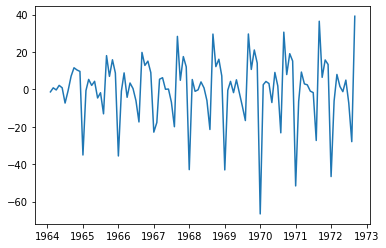

In [59]:
# Using Log transformation and difference method 
df_log=np.sqrt(df['Sales'])
df_diff=df_log.diff().dropna()
plt.plot(df_diff)

In [60]:
adfuller_test(df_diff)

ADF Test Statistic : -4.575580687597258
p-value : 0.0001432393493275833
#Lags Used : 12
Number of Observations Used : 91
Data is Stationary & we reject the null hypothesis


ACF and PACF plots are used to identify the model's order in ARIMA models. These plots help to find the parameters p and q. Also, we always plot the ACF and PACF plots after making the time series stationary.

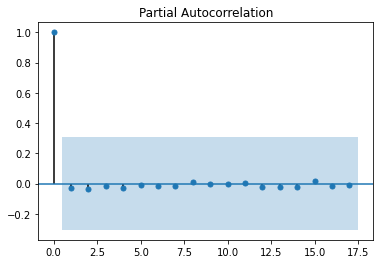

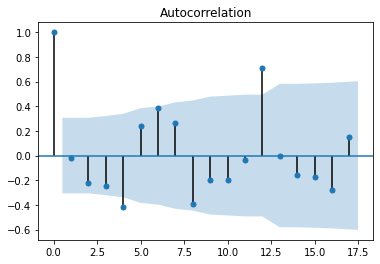

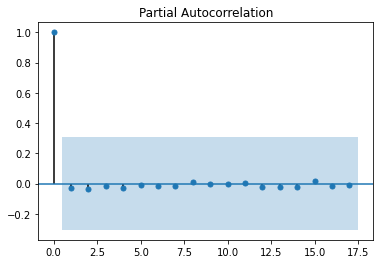

In [61]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
acf_plot=acf(df_diff)
pacf_plot=pacf(df_diff)
plot_acf(acf_plot)
plot_pacf(pacf_plot)

### Model building

#### Train Test Split using indexing

In [62]:
df = df_diff.copy()
train = df.iloc[:80]
test = df.iloc[81:]

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train,order = (1,0,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   80
Model:                     ARMA(1, 1)   Log Likelihood                -325.612
Method:                       css-mle   S.D. of innovations             13.868
Date:                Sun, 29 Jan 2023   AIC                            659.224
Time:                        18:46:17   BIC                            668.752
Sample:                    02-01-1964   HQIC                           663.044
                         - 09-01-1970                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1812      0.115      1.580      0.114      -0.044       0.406
ar.L1.Sales     0.4419      0.102      4.344      0.000       0.243       0.641
ma.L1.Sales    -1.0000      0.035    -28.209      0.000      -1.069      -0.931
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2631           +0.0000j            2.2631            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
df.set_index = ['Month','Sales']

In [44]:
df = pd.DataFrame(df,columns=['Sales','Prediction'])
df

,Sales,Prediction
Month,,
1964-02-01 00:00:00,-1.365182,NaN
1964-03-01 00:00:00,0.796702,NaN
1964-04-01 00:00:00,-0.324888,NaN
1964-05-01 00:00:00,2.113862,NaN
1964-06-01 00:00:00,0.822842,NaN
...,...,...
1972-06-01 00:00:00,4.927601,NaN
1972-07-01 00:00:00,-7.324335,NaN
1972-08-01 00:00:00,-27.969241,NaN


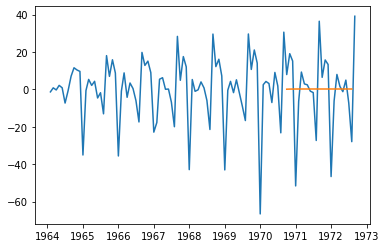

In [65]:
Prediction = model_fit.predict(start = len(train), 
                                    end=len(train)+len(test)- 1)
plt.plot(df)
plt.plot(Prediction)

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
model_sarimax = SARIMAX(train,order=(1,0,1),seasonal_order=(1,0,1,12))
model_sarimax = model_sarimax.fit()

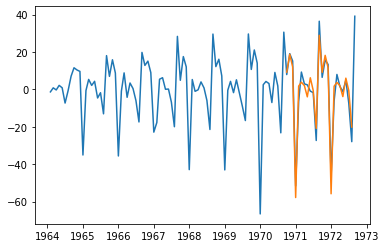

In [68]:
Prediction = model_sarimax.predict(start = len(train), 
                                    end=len(train)+len(test)- 1)
plt.plot(df)
plt.plot(Prediction)

### Predicting the projections for the next 5 years

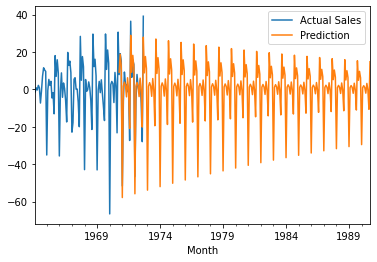

In [73]:
forecast = model_sarimax.forecast(steps=240)
df.plot(label = 'Actual Sales')
forecast.plot(label = "Prediction")
plt.legend()